Using device: mps.
Using Ollama for inference.
No existing feedback data found, starting fresh...
No checkpoint found at 'rlhf_checkpoint.pkl'.

Choose a mode:
1. User-Prompt Feedback
2. Automated-Prompt Feedback
3. Exit

Current stats: 0 interactions, 0 feedback samples
Inference mode: Ollama


Mode 1: User-Prompt Feedback

Enter your prompts and rate the LLM's responses.
Type 'back' to return to main menu, 'train' to force training, 'stats' for statistics.


Thinking...

Response:

<think>

</think>

Not much, just here to help you out! What's up with you? 😄

Rate this response:
1 - Very Poor
2 - Poor
3 - Average
4 - Good
5 - Excellent
Feedback collected: 1.0

Feedback recorded: 1.0

Choose a mode:
1. User-Prompt Feedback
2. Automated-Prompt Feedback
3. Exit

Current stats: 1 interactions, 1 feedback samples
Inference mode: Ollama


Mode 2: Automated-Prompt Feedback

The LLM will generate its own prompts and replies to them. You rate the responses.
Press Enter to generate next prompt

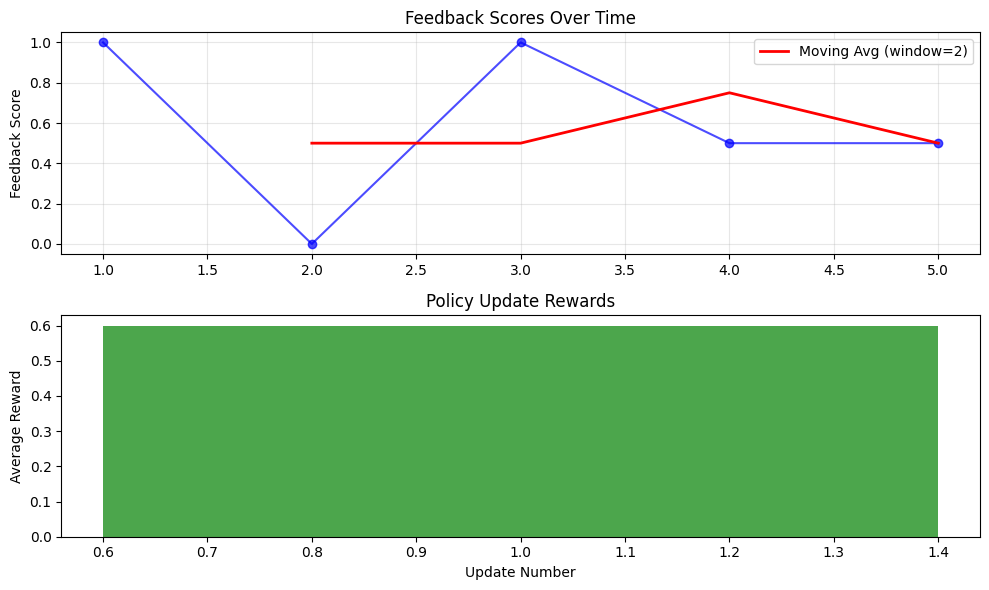


The system ends.
System shutdown completed.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import pickle
from datetime import datetime
import requests
import threading
import time
from collections import deque
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import warnings
import re
warnings.filterwarnings('ignore')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}.")
class DeepSeekChatbot:
    def __init__(self, model_name="deepseek-ai/deepseek-r1-distill-qwen-14b", max_length=512):
        self.model_name = model_name
        self.max_length = max_length
        self.device = device
        self.use_ollama = False
        self.model = None
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token        
        try:
            test_payload = {"model": "deepseek-r1:14b", "prompt": "test", "stream": False}
            response = requests.post("http://localhost:11434/api/generate", json=test_payload, timeout=5)
            if response.status_code == 200:
                self.use_ollama = True
                self.ollama_url = "http://localhost:11434/api/generate"
                print("Using Ollama for inference.")
            else:
                raise Exception("Ollama not responding properly.")
        except:
            print("Ollama not available, will load HuggingFace model when needed...")
    def _load_hf_model(self):
        if self.model is None:
            print("Loading HuggingFace model...")
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                torch_dtype=torch.float16,
                low_cpu_mem_usage=True
            ).to(self.device)
            self.use_ollama = False    
    def get_vocab_size(self):
        return len(self.tokenizer)    
    def generate_response(self, prompt, temperature=0.7, max_tokens=256, return_logits=False):
        if self.use_ollama and not return_logits:
            return self._generate_ollama(prompt, temperature, max_tokens)
        else:
            if self.model is None:
                self._load_hf_model()
            return self._generate_hf(prompt, temperature, max_tokens, return_logits)
    def _generate_ollama(self, prompt, temperature, max_tokens):
        payload = {
            "model": "deepseek-r1:14b",
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": temperature,
                "num_predict": max_tokens}}
        try:
            response = requests.post(self.ollama_url, json=payload, timeout=30)
            if response.status_code == 200:
                return response.json()["response"]
            else:
                return "Error: Failed to generate response."
        except Exception as e:
            return f"Error: {str(e)}"
    def _generate_hf(self, prompt, temperature, max_tokens, return_logits=False):
        try:
            inputs = self.tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=self.max_length).to(self.device)        
            with torch.no_grad():
                outputs = self.model.generate(
                    inputs,
                    max_length=inputs.shape[1] + max_tokens,
                    temperature=temperature,
                    do_sample=True,
                    pad_token_id=self.tokenizer.pad_token_id,
                    attention_mask=torch.ones_like(inputs),
                    return_dict_in_generate=return_logits,
                    output_scores=return_logits)
            if return_logits:
                response_tokens = outputs.sequences[0][inputs.shape[1]:]
                response = self.tokenizer.decode(response_tokens, skip_special_tokens=True)
                logits = torch.stack(outputs.scores, dim=1)
                log_probs = F.log_softmax(logits, dim=-1)
                token_log_probs = log_probs[0, torch.arange(len(response_tokens)), response_tokens]
                return response.strip(), token_log_probs.cpu().numpy(), response_tokens.cpu().numpy()
            else:
                response = self.tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
                return response.strip()
        except Exception as e:
            print(f"Error in HF generation: {e}.")
            return "Error: Failed to generate response." if not return_logits else ("Error: Failed to generate response", np.array([]), np.array([]))
    def generate_with_log_probs(self, prompt, temperature=0.7, max_tokens=256):
        if self.model is None:
            self._load_hf_model()        
        try:
            prompt_tokens = self.tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=self.max_length).to(self.device)
            with torch.no_grad():
                outputs = self.model.generate(
                    prompt_tokens,
                    max_length=prompt_tokens.shape[1] + max_tokens,
                    temperature=temperature,
                    do_sample=True,
                    pad_token_id=self.tokenizer.pad_token_id,
                    attention_mask=torch.ones_like(prompt_tokens),
                    return_dict_in_generate=True,
                    output_scores=True)
            generated_tokens = outputs.sequences[0][prompt_tokens.shape[1]:]
            response_text = self.tokenizer.decode(generated_tokens, skip_special_tokens=True)
            if len(outputs.scores) > 0:
                logits = torch.stack(outputs.scores, dim=0)
                log_probs = F.log_softmax(logits, dim=-1)
                valid_tokens = generated_tokens[:len(outputs.scores)]
                token_log_probs = log_probs[torch.arange(len(valid_tokens)), valid_tokens]
                return response_text.strip(), token_log_probs.cpu().numpy(), valid_tokens.cpu().numpy()
            else:
                return response_text.strip(), np.array([]), np.array([])
        except Exception as e:
            print(f"Error in generate_with_log_probs: {e}.")
            return "Error: Failed to generate response.", np.array([]), np.array([])
    def compute_sequence_log_prob_approximate(self, prompts, responses):
        if self.use_ollama:
            log_probs = []
            for prompt, response in zip(prompts, responses):
                unique_words = len(set(response.lower().split()))
                total_words = len(response.split())
                if total_words == 0:
                    log_prob = -10.0 
                else:
                    length_penalty = -0.1 * total_words
                    diversity_bonus = 0.5 * (unique_words / total_words)
                    coherence_bonus = 0.2 if response.strip().endswith(('.', '!', '?')) else 0                    
                    log_prob = length_penalty + diversity_bonus + coherence_bonus
                log_probs.append(log_prob)
            return log_probs
        else:
            if self.model is None:
                self._load_hf_model()            
            log_probs = []
            for prompt, response in zip(prompts, responses):
                try:
                    prompt_tokens = self.tokenizer.encode(prompt, add_special_tokens=True, truncation=True, max_length=self.max_length)
                    full_text = prompt + response
                    full_tokens = self.tokenizer.encode(full_text, add_special_tokens=True, truncation=True, max_length=self.max_length)
                    response_tokens = full_tokens[len(prompt_tokens):]
                    if len(response_tokens) == 0:
                        log_probs.append(-10.0)
                        continue
                    input_ids = torch.tensor([full_tokens], dtype=torch.long).to(self.device)
                    with torch.no_grad():
                        outputs = self.model(input_ids)
                        logits = outputs.logits[0]
                        log_probs_tensor = F.log_softmax(logits, dim=-1)
                        total_log_prob = 0.0
                        for i, token_id in enumerate(response_tokens):
                            if len(prompt_tokens) + i - 1 < len(log_probs_tensor):
                                token_log_prob = log_probs_tensor[len(prompt_tokens) + i - 1, token_id]
                                total_log_prob += token_log_prob.item()
                        log_probs.append(total_log_prob)
                except Exception as e:
                    print(f"Error in log prob computation: {e}.")
                    log_probs.append(-5.0) 
            return log_probs
    def get_token_logits(self, prompt, response):
        if self.model is None:
            self._load_hf_model()        
        try:
            full_text = prompt + response
            inputs = self.tokenizer(full_text, return_tensors="pt", padding=True, truncation=True, max_length=self.max_length).to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)
                logits = outputs.logits
            prompt_tokens = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=self.max_length)
            prompt_length = prompt_tokens.input_ids.shape[1]
            response_logits = logits[0, prompt_length-1:-1]
            response_tokens = inputs.input_ids[0, prompt_length:]
            log_probs = F.log_softmax(response_logits, dim=-1)
            token_log_probs = log_probs[torch.arange(len(response_tokens)), response_tokens]
            return token_log_probs.cpu().numpy(), response_tokens.cpu().numpy()
        except Exception as e:
            print(f"Error in get_token_logits: {e}.")
            return np.array([]), np.array([])
chatbot = DeepSeekChatbot()
class FeedbackCollector:
    def __init__(self, save_path="feedback_data.json"):
        self.feedback_data = []
        self.save_path = save_path
        self.load_existing_data()
    def load_existing_data(self):
        try:
            with open(self.save_path, 'r') as f:
                self.feedback_data = json.load(f)
            print(f"Loaded {len(self.feedback_data)} existing feedback entries.")
        except FileNotFoundError:
            print("No existing feedback data found, starting fresh...")
    def collect_feedback(self, prompt, response, feedback_score=None):
        if feedback_score is None:
            print(f"\nPrompt: {prompt}")
            print(f"Response: {response}")
            print("Rate this response:")
            print("1 - Very Bad")
            print("2 - Bad")
            print("3 - Neutral")
            print("4 - Good")
            print("5 - Very Good")
            while True:
                try:
                    rating = int(input("Enter rating (1-5): "))
                    if 1 <= rating <= 5:
                        feedback_score = (rating - 3) * 0.5 
                        break
                    else:
                        print("Please enter a number between 1 and 5.")
                except ValueError:
                    print("Please enter a valid number.")
        feedback_entry = {
            "prompt": prompt,
            "response": response,
            "score": feedback_score,
            "timestamp": datetime.now().isoformat()}
        self.feedback_data.append(feedback_entry)
        self.save_data()
        print(f"Feedback collected: {feedback_score}")    
        return feedback_score
    def save_data(self):
        with open(self.save_path, 'w') as f:
            json.dump(self.feedback_data, f, indent=2)
    def get_training_data(self):
        return [(item["prompt"], item["response"], item["score"]) for item in self.feedback_data]
feedback_collector = FeedbackCollector()
class RewardModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, hidden_dim=256, tokenizer=None):
        super(RewardModel, self).__init__()
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.encoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=8, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Tanh())
    def forward(self, input_ids, attention_mask=None):
        input_ids = torch.clamp(input_ids, 0, self.vocab_size - 1)
        embedded = self.embedding(input_ids)        
        lstm_out, _ = self.encoder(embedded)        
        if attention_mask is not None:
            attn_mask = attention_mask.bool()
            attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out, key_padding_mask=~attn_mask)
        else:
            attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)        
        if attention_mask is not None:
            mask_expanded = attention_mask.unsqueeze(-1).expand(attn_out.size())
            pooled = (attn_out * mask_expanded).sum(1) / (mask_expanded.sum(1) + 1e-8)
        else:
            pooled = attn_out.mean(1)        
        reward = self.classifier(pooled)
        return reward.squeeze(-1)
class RewardModelTrainer:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        vocab_size = len(tokenizer) if tokenizer else 50000
        self.model = RewardModel(vocab_size=vocab_size, tokenizer=tokenizer).to(device)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=0.01)
        self.criterion = nn.MSELoss()
    def prepare_training_data(self, feedback_data, max_length=512):
        inputs = []
        targets = []
        for prompt, response, score in feedback_data:
            combined_text = f"{prompt} [SEP] {response}"
            try:
                tokens = self.tokenizer(
                    combined_text,
                    return_tensors="pt",
                    padding="max_length",
                    truncation=True,
                    max_length=max_length)
                inputs.append(tokens.input_ids.squeeze(0))
                targets.append(score)
            except Exception as e:
                print(f"Error tokenizing text: {e}.")
                continue
        if len(inputs) == 0:
            return None, None
        return torch.stack(inputs).to(device), torch.tensor(targets, dtype=torch.float).to(device)
    def train(self, feedback_data, epochs=10, batch_size=8):
        if len(feedback_data) < batch_size:
            print(f"Not enough data for training. Need at least {batch_size} samples, got {len(feedback_data)}.")
            return
        inputs, targets = self.prepare_training_data(feedback_data)
        if inputs is None:
            print("Failed to prepare training data.")
            return
        dataset = torch.utils.data.TensorDataset(inputs, targets)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.model.train()
        losses = []
        for epoch in range(epochs):
            epoch_losses = []
            for batch_inputs, batch_targets in dataloader:
                self.optimizer.zero_grad()
                attention_mask = (batch_inputs != self.tokenizer.pad_token_id).float()                
                outputs = self.model(batch_inputs, attention_mask)
                loss = self.criterion(outputs, batch_targets)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.item())
            avg_loss = np.mean(epoch_losses)
            losses.append(avg_loss)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        return losses
    def predict_reward(self, prompt, response):
        self.model.eval()
        with torch.no_grad():
            combined_text = f"{prompt} [SEP] {response}"
            try:
                tokens = self.tokenizer(
                    combined_text,
                    return_tensors="pt",
                    padding="max_length",
                    truncation=True,
                    max_length=512).to(device)
                attention_mask = (tokens.input_ids != self.tokenizer.pad_token_id).float()
                reward = self.model(tokens.input_ids, attention_mask)
                return reward.item()
            except Exception as e:
                print(f"Error predicting reward: {e}.")
                return 0.0
reward_trainer = RewardModelTrainer(chatbot.tokenizer)
class ImprovedPolicyNetwork(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, hidden_dim=256, tokenizer=None):
        super(ImprovedPolicyNetwork, self).__init__()
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.encoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)        
        self.policy_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, vocab_size))
        self.value_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1))
    def forward(self, input_ids, attention_mask=None):
        input_ids = torch.clamp(input_ids, 0, self.vocab_size - 1)
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.encoder(embedded)
        if attention_mask is not None:
            mask_expanded = attention_mask.unsqueeze(-1).expand(lstm_out.size())
            pooled = (lstm_out * mask_expanded).sum(1) / (mask_expanded.sum(1) + 1e-8)
        else:
            pooled = lstm_out.mean(1)
        policy_logits = self.policy_head(pooled)  
        values = self.value_head(pooled).squeeze(-1) 
        return policy_logits, values
class ImprovedPPOTrainer:
    def __init__(self, reward_model, tokenizer, learning_rate=1e-5):
        self.reward_model = reward_model
        self.tokenizer = tokenizer
        vocab_size = len(tokenizer) if tokenizer else 50000        
        self.policy_network = ImprovedPolicyNetwork(
            vocab_size=vocab_size, 
            tokenizer=tokenizer).to(device)
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=learning_rate)
        self.clip_epsilon = 0.2
        self.value_clip_epsilon = 0.2
        self.entropy_coeff = 0.01
        self.value_coeff = 0.5
        self.kl_coeff = 0.1        
        self.policy_history = []
    def get_action_probabilities_and_values(self, states):
        self.policy_network.eval()        
        all_logits = []
        all_values = []
        with torch.no_grad():
            for state in states:
                tokens = self.tokenizer(
                    state,
                    return_tensors="pt",
                    padding="max_length",
                    truncation=True,
                    max_length=256).to(device)
                attention_mask = (tokens.input_ids != self.tokenizer.pad_token_id).float()
                logits, value = self.policy_network(tokens.input_ids, attention_mask)
                all_logits.append(logits)
                all_values.append(value.item())
        return all_logits, all_values
    def compute_log_probs_from_policy(self, states, actions):
        self.policy_network.train() 
        log_probs = []
        for state, action in zip(states, actions):
            state_tokens = self.tokenizer(
                state,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=256).to(device)
            action_tokens = self.tokenizer.encode(action, add_special_tokens=False)            
            attention_mask = (state_tokens.input_ids != self.tokenizer.pad_token_id).float()
            logits, _ = self.policy_network(state_tokens.input_ids, attention_mask)
            log_probs_action = F.log_softmax(logits[0], dim=-1) 
            total_log_prob = torch.tensor(0.0, requires_grad=True, device=device)
            for token_id in action_tokens:
                if token_id < len(log_probs_action):
                    total_log_prob = total_log_prob + log_probs_action[token_id]            
            log_probs.append(total_log_prob)
        return log_probs
    def compute_advantages(self, rewards, values, gamma=0.99, lam=0.95):
        advantages = []
        gae = 0        
        for i in reversed(range(len(rewards))):
            if i == len(rewards) - 1:
                next_value = 0
            else:
                next_value = values[i + 1]
            delta = rewards[i] + gamma * next_value - values[i]
            gae = delta + gamma * lam * gae
            advantages.insert(0, gae)
        return np.array(advantages)
    def update_policy(self, states, actions, old_log_probs, rewards, epochs=4):        
        _, current_values = self.get_action_probabilities_and_values(states)
        advantages = self.compute_advantages(rewards, current_values)        
        returns = []
        discounted_sum = 0
        for reward in reversed(rewards):
            discounted_sum = reward + 0.99 * discounted_sum
            returns.insert(0, discounted_sum)
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)        
        old_log_probs_tensor = torch.tensor(old_log_probs, dtype=torch.float).to(device)
        advantages_tensor = torch.tensor(advantages, dtype=torch.float, requires_grad=True).to(device)
        returns_tensor = torch.tensor(returns, dtype=torch.float, requires_grad=True).to(device)
        current_values_tensor = torch.tensor(current_values, dtype=torch.float, requires_grad=True).to(device)        
        total_losses = []
        for epoch in range(epochs):
            self.policy_network.train()            
            current_log_probs = self.compute_log_probs_from_policy(states, actions)
            current_log_probs_tensor = torch.stack(current_log_probs).to(device)
            ratio = torch.exp(current_log_probs_tensor - old_log_probs_tensor)
            ratio = torch.clamp(ratio, 0.1, 10.0)             
            surr1 = ratio * advantages_tensor
            surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages_tensor
            policy_loss = -torch.min(surr1, surr2).mean()            
            value_loss = 0.5 * (current_values_tensor - returns_tensor).pow(2).mean()            
            entropy_loss = 0.0 
            kl_penalty = self.kl_coeff * (current_log_probs_tensor - old_log_probs_tensor).pow(2).mean()            
            total_loss = policy_loss + self.value_coeff * value_loss + kl_penalty            
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), 0.5)
            self.optimizer.step()            
            total_losses.append(total_loss.item())
            if kl_penalty.item() > 0.15:
                print(f"Early stopping at epoch {epoch} due to high KL divergence.")
                break
        update_info = {
            "timestamp": datetime.now().isoformat(),
            "avg_reward": np.mean(rewards),
            "avg_advantage": np.mean(advantages),
            "num_samples": len(states),
            "policy_loss": policy_loss.item(),
            "value_loss": value_loss.item(),
            "kl_penalty": kl_penalty.item(),
            "total_loss": np.mean(total_losses)}
        self.policy_history.append(update_info)
        return update_info
class RLHFChatbot:
    def __init__(self):
        self.chatbot = chatbot
        self.feedback_collector = feedback_collector
        self.reward_trainer = reward_trainer
        self.ppo_trainer = ImprovedPPOTrainer(reward_trainer, chatbot.tokenizer)
        self.conversation_history = []
        self.training_interval = 5 
        self.interaction_count = 0
        self.prompt_categories = {
            "general_knowledge": [
                "What is",
                "How does",
                "Explain",
                "What are the benefits of",
                "What is the difference between"
            ],
            "creative": [
                "Write a short story about",
                "Create a poem about",
                "Describe a fictional character who",
                "Imagine a world where",
                "Tell me a joke about"
            ],
            "advice": [
                "How can I improve",
                "What should I do when",
                "Give me tips for",
                "How do I handle",
                "What's the best way to"
            ],
            "technical": [
                "How do you implement",
                "What is the algorithm for",
                "Explain the concept of",
                "How does machine learning",
                "What are the steps to"
            ]}
    def generate_automated_prompt(self):
        category = np.random.choice(list(self.prompt_categories.keys()))
        starter = np.random.choice(self.prompt_categories[category])
        meta_prompt = f"Complete this prompt starter to create an interesting question: '{starter}' - provide only the completed question, nothing else."
        generated_prompt = self.chatbot.generate_response(meta_prompt, temperature=0.8, max_tokens=50)        
        generated_prompt = generated_prompt.strip()
        if not generated_prompt.endswith('?'):
            generated_prompt += '?'
        return generated_prompt
    def user_prompt_mode(self):
        print("\nMode 1: User-Prompt Feedback")
        print("\nEnter your prompts and rate the LLM's responses.")
        print("Type 'back' to return to main menu, 'train' to force training, 'stats' for statistics.")
        print()
        while True:
            user_input = input("Your prompt: ").strip()            
            if user_input.lower() == 'back':
                break
            elif user_input.lower() == 'train':
                self.train_models()
                continue
            elif user_input.lower() == 'stats':
                self.show_statistics()
                continue
            elif not user_input:
                print("Please enter a prompt or type 'back' to return.")
                continue
            print("\nThinking...")
            response = self.chatbot.generate_response(user_input)
            print(f"\nResponse:\n")
            print(response)
            feedback_score = self.collect_user_feedback()            
            self.store_interaction(user_input, response, feedback_score)
            print(f"\nFeedback recorded: {feedback_score}")
    def automated_prompt_mode(self):
        print("\nMode 2: Automated-Prompt Feedback")
        print("\nThe LLM will generate its own prompts and replies to them. You rate the responses.")
        print("Press Enter to generate next prompt, type 'back' to return to main menu.")
        while True:
            user_input = input("Press Enter for next automated prompt (or type 'back' to return): ").strip()
            if user_input.lower() == 'back':
                break
            elif user_input.lower() == 'train':
                self.train_models()
                continue
            elif user_input.lower() == 'stats':
                self.show_statistics()
                continue            
            print("\nGenerating prompt...")
            automated_prompt = self.generate_automated_prompt()
            print(f"\nGenerated prompt:")
            print(automated_prompt)            
            print("\nResponding to its own prompt...")
            response = self.chatbot.generate_response(automated_prompt)
            print(f"\nResponse:\n")
            print(response)            
            feedback_score = self.collect_user_feedback()
            self.store_interaction(automated_prompt, response, feedback_score)            
            print(f"\nFeedback recorded: {feedback_score}\n")
    def collect_user_feedback(self):
        print("\nRate this response:")
        print("1 - Very Poor")
        print("2 - Poor")
        print("3 - Average")
        print("4 - Good")
        print("5 - Excellent")
        while True:
            try:
                rating = input("Enter rating (1-5): ").strip()
                rating_num = int(rating)
                if 1 <= rating_num <= 5:
                    feedback_score = (rating_num - 3) * 0.5  
                    return feedback_score
                else:
                    print("Please enter a number between 1 and 5.")
            except ValueError:
                print("Please enter a valid number (1-5).")
    def store_interaction(self, prompt, response, feedback_score):
        self.feedback_collector.collect_feedback(prompt, response, feedback_score)
        self.conversation_history.append({
            "prompt": prompt,
            "response": response,
            "feedback": feedback_score,
            "timestamp": datetime.now().isoformat()})
        self.interaction_count += 1
        if self.interaction_count % self.training_interval == 0:
            print("\nAutomatic Training Triggered...\n")
            print(f"Training after {self.interaction_count} interactions...\n")
            self.train_models()
    def train_models(self):
        feedback_data = self.feedback_collector.get_training_data()
        if len(feedback_data) < 3:
            print("Not enough feedback data for training.")
            return
        print(f"Training with {len(feedback_data)} feedback samples...")        
        print("Training reward model...")
        losses = self.reward_trainer.train(feedback_data, epochs=5, batch_size=min(4, len(feedback_data)))
        print("Updating policy...")
        if len(self.conversation_history) > 0:
            states = [conv["prompt"] for conv in self.conversation_history]
            actions = [conv["response"] for conv in self.conversation_history]
            rewards = [conv["feedback"] for conv in self.conversation_history]            
            old_log_probs = self.chatbot.compute_sequence_log_prob_approximate(states, actions)
            update_info = self.ppo_trainer.update_policy(states, actions, old_log_probs, rewards)
            print(f"Policy update completed. Avg reward: {update_info['avg_reward']:.3f}.")
    def show_statistics(self):
        print("\nStatistics:")
        print(f"Total interactions: {len(self.conversation_history)}")
        print(f"Total feedback samples: {len(self.feedback_collector.feedback_data)}")
        print(f"Using {'Ollama' if self.chatbot.use_ollama else 'HuggingFace'} for inference.")
        if self.conversation_history:
            avg_feedback = np.mean([conv["feedback"] for conv in self.conversation_history])
            print(f"Average feedback score: {avg_feedback:.3f}")
            if len(self.conversation_history) >= 5:
                recent_avg = np.mean([conv["feedback"] for conv in self.conversation_history[-5:]])
                print(f"Recent average (last 5): {recent_avg:.3f}")
        if self.ppo_trainer.policy_history:
            print(f"Policy updates: {len(self.ppo_trainer.policy_history)}")
            recent_update = self.ppo_trainer.policy_history[-1]
            print(f"Last update avg reward: {recent_update['avg_reward']:.3f}")
    def evaluate_improvement(self, test_prompts):
        print("\nEvaluation:")
        for prompt in test_prompts:
            response = self.chatbot.generate_response(prompt)
            predicted_reward = self.reward_trainer.predict_reward(prompt, response)
            print(f"Prompt: {prompt}")
            print(f"Response: {response}")
            print(f"Predicted reward: {predicted_reward:.3f}")
            print("\n")
    def main_menu(self):
        while True:
            print("\nChoose a mode:")
            print("1. User-Prompt Feedback")
            print("2. Automated-Prompt Feedback") 
            print("3. Exit")
            print(f"\nCurrent stats: {len(self.conversation_history)} interactions, "
                  f"{len(self.feedback_collector.feedback_data)} feedback samples")
            print(f"Inference mode: {'Ollama' if self.chatbot.use_ollama else 'HuggingFace'}\n")
            choice = input("Enter your choice (1-3): ").strip()
            if choice == '1':
                self.user_prompt_mode()
            elif choice == '2':
                self.automated_prompt_mode()
            elif choice == '3':
                self.exit_system()
                break
            else:
                print("Invalid choice. Please enter 1, 2, or 3.")
    def exit_system(self):
        print("\nThe system ends.\n")        
        if self.conversation_history:
            print("Final Statistics:")
            self.show_statistics()
            save_choice = input("\nSave progress before exiting? (y/n): ").strip().lower()
            if save_choice in ['y', 'yes']:
                save_model_checkpoint(self)
                print("Progress saved.")
            plot_choice = input("Show training progress plots? (y/n): ").strip().lower()
            if plot_choice in ['y', 'yes']:
                plot_training_progress(self)
        print("\nThe system ends.")
def start_rlhf_system():
    rlhf_bot = RLHFChatbot()    
    checkpoint_loaded = load_model_checkpoint(rlhf_bot)
    if checkpoint_loaded:
        print("Previous session data loaded successfully.")    
    rlhf_bot.main_menu()
    return rlhf_bot
def plot_training_progress(rlhf_bot):
    if not rlhf_bot.conversation_history:
        print("No conversation history available to plot.")
        return
    feedbacks = [conv["feedback"] for conv in rlhf_bot.conversation_history]
    interactions = range(1, len(feedbacks) + 1)
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(interactions, feedbacks, 'b-o', alpha=0.7)
    plt.title('Feedback Scores Over Time')
    plt.ylabel('Feedback Score')
    plt.grid(True, alpha=0.3)
    if len(feedbacks) > 3:
        window = min(5, len(feedbacks) // 2)
        moving_avg = np.convolve(feedbacks, np.ones(window)/window, mode='valid')
        plt.plot(range(window, len(feedbacks)+1), moving_avg, 'r-', linewidth=2, label=f'Moving Avg (window={window})')
        plt.legend()
    plt.subplot(2, 1, 2)
    if rlhf_bot.ppo_trainer.policy_history:
        update_rewards = [update["avg_reward"] for update in rlhf_bot.ppo_trainer.policy_history]
        update_times = range(1, len(update_rewards) + 1)
        plt.bar(update_times, update_rewards, alpha=0.7, color='green')
        plt.title('Policy Update Rewards')
        plt.ylabel('Average Reward')
        plt.xlabel('Update Number')    
    plt.tight_layout()
    plt.show()
def save_model_checkpoint(rlhf_bot, checkpoint_path="rlhf_checkpoint.pkl"):
    checkpoint = {
        "reward_model_state": rlhf_bot.reward_trainer.model.state_dict(),
        "optimizer_state": rlhf_bot.reward_trainer.optimizer.state_dict(),
        "conversation_history": rlhf_bot.conversation_history,
        "policy_history": rlhf_bot.ppo_trainer.policy_history,
        "feedback_data": rlhf_bot.feedback_collector.feedback_data,
        "vocab_size": rlhf_bot.reward_trainer.model.vocab_size,
        "use_ollama": rlhf_bot.chatbot.use_ollama}
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(checkpoint, f) 
    print(f"Checkpoint saved to '{checkpoint_path}'.")
def load_model_checkpoint(rlhf_bot, checkpoint_path="rlhf_checkpoint.pkl"):
    try:
        with open(checkpoint_path, 'rb') as f:
            checkpoint = pickle.load(f)
        checkpoint_vocab_size = checkpoint.get("vocab_size", 50000)
        current_vocab_size = len(rlhf_bot.reward_trainer.tokenizer)
        if checkpoint_vocab_size != current_vocab_size:
            print(f"Vocabulary size mismatch: checkpoint has {checkpoint_vocab_size}, current model expects {current_vocab_size}.")
            rlhf_bot.reward_trainer.model = RewardModel(
                vocab_size=current_vocab_size,
                tokenizer=rlhf_bot.reward_trainer.tokenizer
            ).to(device)
            rlhf_bot.reward_trainer.optimizer = optim.AdamW(
                rlhf_bot.reward_trainer.model.parameters(),
                lr=1e-4,
                weight_decay=0.01)
        else:
            rlhf_bot.reward_trainer.model.load_state_dict(checkpoint["reward_model_state"])
            rlhf_bot.reward_trainer.optimizer.load_state_dict(checkpoint["optimizer_state"])
        rlhf_bot.conversation_history = checkpoint["conversation_history"]
        rlhf_bot.ppo_trainer.policy_history = checkpoint["policy_history"]
        rlhf_bot.feedback_collector.feedback_data = checkpoint["feedback_data"]
        rlhf_bot.chatbot.use_ollama = checkpoint.get("use_ollama", False)
        print(f"Checkpoint loaded from '{checkpoint_path}'.")
        return True
    except FileNotFoundError:
        print(f"No checkpoint found at '{checkpoint_path}'.")
        return False
    except Exception as e:
        print(f"Error loading checkpoint: {e}.")
        return False
if __name__ == "__main__":
    rlhf_bot = start_rlhf_system()
    print("System shutdown completed.")